In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection._search import GridSearchCV
from sklearn.model_selection._split import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, SelectFdr

import optuna
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.model_selection import RepeatedKFold

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Lendo o Dataset:

In [2]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\Estudo_dados_de_covid\Data\Casos Graves\df_casos_graves')

### Utilizando a class 'Pre_processing_models' para fazer o pré-processamento:

In [3]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']

In [4]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.460870,0,1,2020-05-30
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2020-06-02
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.747826,1,0,2020-06-02
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,0,1,2020-06-01
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.591304,0,1,2020-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.669565,0,1,2022-06-08
36431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.643478,0,1,2022-06-09
36432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.643478,0,1,2022-06-10
36433,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.634783,1,0,2022-06-12


In [5]:
df2 = pd.DataFrame()
df2 = df
df2.set_index('data_notificacao', inplace=True)
df2.sort_index(inplace=True)
df2

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\943203674.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-02-26,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.356522,0,1
2020-02-26,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.278261,0,1
2020-02-27,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.217391,1,0
2020-02-27,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0.278261,0,1
2020-02-27,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.260870,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2022-06-12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.556522,0,1
2022-06-12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.573913,1,0


### Criação de uma função para instância do modelo, utilizando repeated K-fold:

In [6]:
from sklearn.metrics import f1_score, make_scorer

def KNN_model (X_train, y_train):
    k_range = range(1, 31)
    param_grid = {"n_neighbors": k_range}
    #scores = ['accuracy','f1','precision','recall','roc_auc']

    f1 = make_scorer(f1_score , average='macro')

    #Init classifier
    knn = KNeighborsClassifier()

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(knn, param_grid, n_jobs = -1, cv=5, scoring = 'roc_auc')
    #grid_cv = GridSearchCV(knn, param_grid, n_jobs = -1, cv=cv, scoring = scores, refit='accuracy')

    # Fit 
    grid_cv.fit(X_train, y_train)

    #mean_test_score = grid_cv.cv_results_['mean_test_score']
    #std_test_score = grid_cv.cv_results_['std_test_score']
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

   

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    #return mean_test_score, std_test_score, best_score, best_params
    return best_score, best_params

#### Aplicação do modelo para o dataset inteiro:

In [7]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 2)

#utilizando diferentes random_states para mudar os conjuntos de treino e teste
#list_random_states = [0,12,42,50,54,68,79,81,92,112]
list_random_states = [42]

#listas para armazenar os resultados
#mean_test_scores = []
#std_test_scores = []
best_scores = []
best_params = []

X = df2.drop(labels=['death'], axis=1)
y = df2['death']

# X = df2[["SYMPTOM_COUGH", "SYMPTOM_AIR_INSUFFICIENCY", "SYMPTOM_FEVER", 'SYMPTOM_THROAT_CONDITION', 'SYMPTOM_HEADACHE', 'SYMPTOM_COLD', 'SYMPTOM_DIARRHEA','SYMPTOM_LOW_OXYGEN_SATURATION', 'SYMPTOM_BREATHING_CONDITION',
#     'DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY', 'DISEASE_TABAGIST', 'DISEASE_KIDNEY', 'DISEASE_IMMUNOSUPPRESSION', 'DISEASE_ETILISM', 'DISEASE_LIVER',
#     'sexo_Feminino','sexo_Masculino']]

# y = df2['death'].astype(int)

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #mean_test_score, std_test_score, best_score, best_param = KNN_model(X_train,y_train)
    best_score, best_param = KNN_model(X_train,y_train)

    #mean_test_scores.append(mean_test_score)
    #std_test_scores.append(std_test_score)
    best_scores.append(best_score)
    best_params.append(best_param)

########################################

best_score: 0.7927820131625383
best_params_: {'n_neighbors': 29}
########################################



In [8]:
X_train.index

Index(['2020-02-26', '2020-02-26', '2020-02-27', '2020-02-27', '2020-02-27',
       '2020-02-27', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-04',
       ...
       '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13',
       '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13'],
      dtype='object', name='data_notificacao', length=24290)

In [9]:
X_test.index

Index(['2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13',
       '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13', '2021-04-13',
       ...
       '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12',
       '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-13', '2022-06-13'],
      dtype='object', name='data_notificacao', length=12145)

## Testando o modelo para os melhores parâmetros:

In [10]:
print(f'Best_score = {max(best_scores)}')
index = best_scores.index(max(best_scores))
print(f'Best_params = {best_params[index]}')

Best_score = 0.7927820131625383
Best_params = {'n_neighbors': 29}


In [11]:
# parametrizando o modelo final
final_cl = KNeighborsClassifier(n_neighbors=29)

#treinando o modelo final
final_cl.fit(X_train, y_train)


preds = final_cl.predict(X_test)

accuracy_score(y_test, preds)

0.7030053519967064

In [12]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.39429051217464317
0.5987814709768771
0.7030053519967064
0.6885756482755443


In [13]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.4605727736367203
0.6139879291276557
0.7030053519967064
0.6813541723745192


In [14]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.5936725958384593

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


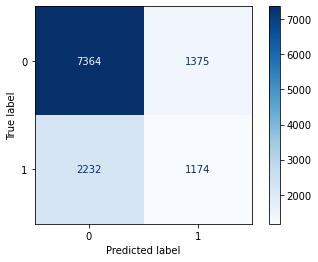

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      8739
           1       0.46      0.34      0.39      3406

    accuracy                           0.70     12145
   macro avg       0.61      0.59      0.60     12145
weighted avg       0.68      0.70      0.69     12145



In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

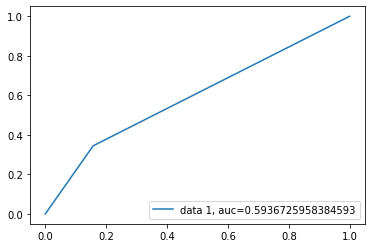

In [16]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Aplicando para os períodos de 6 meses:

In [17]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\Estudo_dados_de_covid\Data\Casos Graves\df_casos_graves')

In [18]:
periodo_1 = df[(df['data_notificacao'] > '2020-02-26') & (df['data_notificacao'] < '2020-08-31')]
periodo_2 = df[(df['data_notificacao'] > '2020-09-01') & (df['data_notificacao'] < '2021-02-28')]
periodo_3 = df[(df['data_notificacao'] > '2021-03-01') & (df['data_notificacao'] < '2021-08-31')]
periodo_4 = df[(df['data_notificacao'] > '2021-09-01') & (df['data_notificacao'] < '2022-02-28')]
periodo_5 = df[(df['data_notificacao'] > '2022-03-01') & (df['data_notificacao'] < '2022-06-13')]

#### Criando listas para armazenamento dos melhores parâmetros:

In [19]:
best_scores_periodos_6meses = []
best_params_periodos_6meses = []

#### Período 1 (26/02/2020 até 31/08/2020):

In [20]:
Pre_processing_models_1 = Pre_processing_models(periodo_1)
Pre_processing_models_1.run_graves()

df_p1 = Pre_processing_models_1.df
df_p1 = df_p1[list_features]
df_p1

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.486239,0,1,2020-05-30
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2020-06-02
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.788991,1,0,2020-06-02
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.605505,0,1,2020-06-01
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.623853,0,1,2020-06-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36273,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0.211009,1,0,2020-05-31
36274,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.614679,0,1,2020-05-13
36275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.623853,0,1,2020-05-12
36276,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.752294,1,0,2020-07-31


In [21]:
df2_p1 = pd.DataFrame()
df2_p1 = df_p1
df2_p1.set_index('data_notificacao', inplace=True)
df2_p1.sort_index(inplace=True)
df2_p1

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\2202701414.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p1.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-02-27,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.330275,0,1
2020-02-27,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0.293578,0,1
2020-02-27,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.229358,1,0
2020-02-27,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.275229,1,0
2020-02-29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.238532,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.504587,1,0
2020-08-30,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.467890,0,1
2020-08-30,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.788991,0,1


#### Aplicação do modelo:

In [22]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_1 = []
best_params_1 = []

"""X = df_p1[["SYMPTOM_COUGH", "SYMPTOM_AIR_INSUFFICIENCY", "SYMPTOM_FEVER", 'SYMPTOM_THROAT_CONDITION', 'SYMPTOM_HEADACHE',
    'DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY', 'DISEASE_TABAGIST', 'idade', 'sexo_Feminino','sexo_Masculino']]

y = df_p1['death'].astype(int)"""

X = df2_p1.drop(labels=['death'], axis=1)
y = df2_p1['death']

for random_state in list_random_states:
    
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #mean_test_score, std_test_score, best_score, best_param = KNN_model(X_train,y_train)
    best_score, best_param = KNN_model(X_train,y_train)

    best_scores_1.append(best_score)
    best_params_1.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
best_scores_periodos_6meses.append(best_scores_1)
best_params_periodos_6meses.append(best_params_1)

########################################

best_score: 0.8631378523307942
best_params_: {'n_neighbors': 29}
########################################



In [23]:
X_train.index

Index(['2020-02-27', '2020-02-27', '2020-02-27', '2020-02-27', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-04', '2020-03-04', '2020-03-04',
       ...
       '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26',
       '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26'],
      dtype='object', name='data_notificacao', length=10914)

In [24]:
X_test.index

Index(['2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26',
       '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26', '2020-05-26',
       ...
       '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30',
       '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30'],
      dtype='object', name='data_notificacao', length=5457)

In [25]:
print(f'Best_score = {max(best_scores_periodos_6meses[0])}')
index = best_scores_periodos_6meses[0].index(max(best_scores_periodos_6meses[0]))
print(f'Best_params = {best_params_periodos_6meses[0][index]}')

Best_score = 0.8631378523307942
Best_params = {'n_neighbors': 29}


## Testando o modelo para os melhores parâmetros:

In [26]:
# parametrizando o modelo final
final_cl_p1 = KNeighborsClassifier(n_neighbors=29)

#treinando o modelo final
final_cl_p1.fit(X_train, y_train)


preds = final_cl_p1.predict(X_test)

accuracy_score(y_test, preds)

0.7379512552684625

In [27]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.44357976653696496
0.6360995668734681
0.7379512552684626
0.7432431684167996


In [28]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.41911764705882354
0.6314528923602636
0.7379512552684625
0.7496244408265407


In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6425303617332215

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


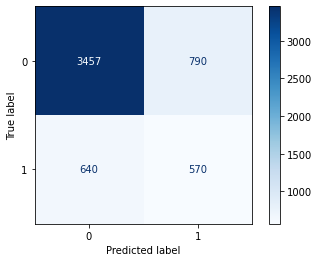

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      4247
           1       0.42      0.47      0.44      1210

    accuracy                           0.74      5457
   macro avg       0.63      0.64      0.64      5457
weighted avg       0.75      0.74      0.74      5457



In [30]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p1, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

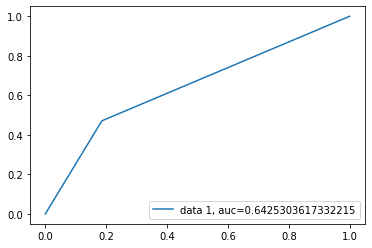

In [31]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 2 (01/09/2020 até 28/02/2021):

In [32]:
Pre_processing_models_2 = Pre_processing_models(periodo_2)
Pre_processing_models_2.run_graves()

df_p2 = Pre_processing_models_2.df
df_p2 = df_p2[list_features]
df_p2

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.736842,0,1,2020-09-16
432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.166667,0,1,2020-09-27
433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.798246,1,0,2020-09-30
434,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.500000,0,1,2020-09-30
436,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.736842,1,0,2020-11-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36245,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.666667,1,0,2021-01-18
36246,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.570175,1,0,2020-12-30
36247,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.429825,0,1,2021-02-02
36351,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.798246,1,0,2021-01-13


In [33]:
df2_p2 = pd.DataFrame()
df2_p2 = df_p2
df2_p2.set_index('data_notificacao', inplace=True)
df2_p2.sort_index(inplace=True)
df2_p2

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\4255314209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p2.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-09-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.201754,1,0
2020-09-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.500000,0,1
2020-09-02,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.026316,0,1
2020-09-02,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.508772,0,1
2020-09-02,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.552632,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.789474,0,1
2021-02-27,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0.464912,1,0
2021-02-27,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.368421,1,0


#### Aplicação do modelo:

In [34]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_2 = []
best_params_2 = []

"""X = df_p2[["SYMPTOM_COUGH", "SYMPTOM_AIR_INSUFFICIENCY", "SYMPTOM_FEVER", 'SYMPTOM_THROAT_CONDITION', 'SYMPTOM_HEADACHE',
    'DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY', 'DISEASE_TABAGIST', 'idade', 'sexo_Feminino','sexo_Masculino']]

y = df_p2['death'].astype(int)"""
X = df2_p2.drop(labels=['death'], axis=1)
y = df2_p2['death']

for random_state in list_random_states:
    
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #mean_test_score, std_test_score, best_score, best_param = KNN_model(X_train,y_train)
    best_score, best_param = KNN_model(X_train,y_train)

    best_scores_2.append(best_score)
    best_params_2.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
best_scores_periodos_6meses.append(best_scores_2)
best_params_periodos_6meses.append(best_params_2)


########################################

best_score: 0.7363260928708459
best_params_: {'n_neighbors': 30}
########################################



In [35]:
X_train.index

Index(['2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02',
       '2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02',
       ...
       '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07',
       '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07'],
      dtype='object', name='data_notificacao', length=3383)

In [36]:
X_test.index

Index(['2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07',
       '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07', '2021-01-07',
       ...
       '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27',
       '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27'],
      dtype='object', name='data_notificacao', length=1691)

In [69]:
print(f'Best_score = {max(best_scores_periodos_6meses[1])}')
index = best_scores_periodos_6meses[1].index(max(best_scores_periodos_6meses[1]))
print(f'Best_params = {best_params_periodos_6meses[1][index]}')

Best_score = 0.7291189797914148
Best_params = {'n_neighbors': 27}


## Testando o modelo para os melhores parâmetros:

In [37]:
# parametrizando o modelo final
final_cl_p2 = KNeighborsClassifier(n_neighbors=27)

#treinando o modelo final
final_cl_p2.fit(X_train, y_train)


preds = final_cl_p2.predict(X_test)

accuracy_score(y_test, preds)

0.706682436428149

In [38]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.4232558139534884
0.6132932519410582
0.706682436428149
0.6711698223512289


In [40]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.6691176470588235
0.6915003316337105
0.706682436428149
0.6983170569773338


In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6139640806458576

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


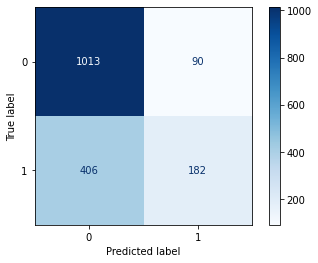

              precision    recall  f1-score   support

           0       0.71      0.92      0.80      1103
           1       0.67      0.31      0.42       588

    accuracy                           0.71      1691
   macro avg       0.69      0.61      0.61      1691
weighted avg       0.70      0.71      0.67      1691



In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p2, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

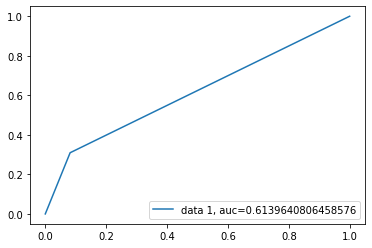

In [43]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 3 (01/03/2021 até 31/08/2021):

In [44]:
Pre_processing_models_3 = Pre_processing_models(periodo_3)
Pre_processing_models_3.run_graves()

df_p3 = Pre_processing_models_3.df
df_p3 = df_p3[list_features]
df_p3

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
952,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.429825,0,1,2021-05-07
953,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.315789,1,0,2021-04-27
954,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.368421,1,0,2021-04-14
955,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.394737,0,1,2021-04-10
956,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.377193,0,1,2021-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.622807,1,0,2021-06-09
36366,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0.508772,1,0,2021-05-29
36371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.403509,0,1,2021-07-01
36372,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.622807,0,1,2021-06-18


In [45]:
df2_p3 = pd.DataFrame()
df2_p3 = df_p3
df2_p3.set_index('data_notificacao', inplace=True)
df2_p3.sort_index(inplace=True)
df2_p3

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\289666993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p3.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2021-03-02,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0.552632,1,0
2021-03-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.421053,1,0
2021-03-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.684211,0,1
2021-03-02,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.622807,1,0
2021-03-02,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.543860,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30,1,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0.324561,1,0
2021-08-30,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.508772,1,0
2021-08-30,1,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0.657895,0,1


#### Aplicação do modelo:

In [46]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_3 = []
best_params_3 = []

"""X = df_p3[["SYMPTOM_COUGH", "SYMPTOM_AIR_INSUFFICIENCY", "SYMPTOM_FEVER", 'SYMPTOM_THROAT_CONDITION', 'SYMPTOM_HEADACHE',
    'DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY', 'DISEASE_TABAGIST', 'idade', 'sexo_Feminino','sexo_Masculino']]

y = df_p3['death'].astype(int)"""

X = df2_p3.drop(labels=['death'], axis=1)
y = df2_p3['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    #mean_test_score, std_test_score, best_score, best_param = KNN_model(X_train,y_train)
    best_score, best_param = KNN_model(X_train,y_train)

    best_scores_3.append(best_score)
    best_params_3.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
best_scores_periodos_6meses.append(best_scores_3)
best_params_periodos_6meses.append(best_params_3)

########################################

best_score: 0.7629956664118748
best_params_: {'n_neighbors': 30}
########################################



In [47]:
X_train.index

Index(['2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02',
       '2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02',
       ...
       '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02',
       '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02'],
      dtype='object', name='data_notificacao', length=5810)

In [48]:
X_test.index

Index(['2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02',
       '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02',
       ...
       '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30',
       '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30'],
      dtype='object', name='data_notificacao', length=2904)

In [49]:
print(f'Best_score = {max(best_scores_periodos_6meses[2])}')
index = best_scores_periodos_6meses[2].index(max(best_scores_periodos_6meses[2]))
print(f'Best_params = {best_params_periodos_6meses[2][index]}')

Best_score = 0.7629956664118748
Best_params = {'n_neighbors': 30}


## Testando o modelo para os melhores parâmetros:

In [50]:
# parametrizando o modelo final
final_cl_p3 = KNeighborsClassifier(n_neighbors=30)

#treinando o modelo final
final_cl_p3.fit(X_train, y_train)


preds = final_cl_p3.predict(X_test)

accuracy_score(y_test, preds)

0.7520661157024794

In [51]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.5006934812760057
0.667891403945378
0.7520661157024794
0.7345633028610574


In [52]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.6344463971880492
0.7075872242899561
0.7520661157024794
0.7367528846838983


In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.655552002382318

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


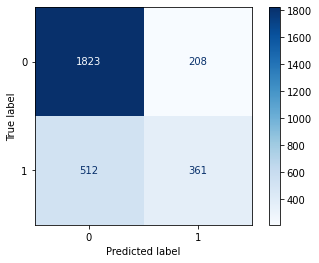

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      2031
           1       0.63      0.41      0.50       873

    accuracy                           0.75      2904
   macro avg       0.71      0.66      0.67      2904
weighted avg       0.74      0.75      0.73      2904



In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p3, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

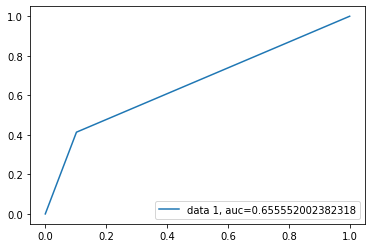

In [55]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 4 (01/09/2021 até 28/02/2022):

In [56]:
Pre_processing_models_4 = Pre_processing_models(periodo_4)
Pre_processing_models_4.run_graves()

df_p4 = Pre_processing_models_4.df
df_p4 = df_p4[list_features]
df_p4

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
1804,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.252174,0,1,2021-09-18
1805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.243478,1,0,2021-09-25
1807,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.721739,0,1,2021-09-08
1808,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2021-10-07
1809,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0.530435,0,1,2021-10-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36360,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.234783,0,1,2022-02-26
36361,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.582609,0,1,2021-12-30
36368,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.756522,0,1,2022-02-02
36385,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.800000,0,1,2021-11-22


In [57]:
df2_p4 = pd.DataFrame()
df2_p4 = df_p4
df2_p4.set_index('data_notificacao', inplace=True)
df2_p4.sort_index(inplace=True)
df2_p4

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\2179922053.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p4.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2021-09-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.617391,0,1
2021-09-02,1,0,1,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0.426087,0,1
2021-09-02,1,0,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0.382609,0,1
2021-09-02,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.765217,1,0
2021-09-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.095652,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.591304,1,0
2022-02-27,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.460870,1,0
2022-02-27,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,1


#### Aplicação do modelo:

In [58]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_4 = []
best_params_4 = []

"""X = df_p4[["SYMPTOM_COUGH", "SYMPTOM_AIR_INSUFFICIENCY", "SYMPTOM_FEVER", 'SYMPTOM_THROAT_CONDITION', 'SYMPTOM_HEADACHE',
    'DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY', 'DISEASE_TABAGIST', 'idade', 'sexo_Feminino','sexo_Masculino']]

y = df_p4['death'].astype(int)"""
X = df2_p4.drop(labels=['death'], axis=1)
y = df2_p4['death']

for random_state in list_random_states:
    
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #mean_test_score, std_test_score, best_score, best_param = KNN_model(X_train,y_train)
    best_score, best_param = KNN_model(X_train,y_train)

    best_scores_4.append(best_score)
    best_params_4.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
best_scores_periodos_6meses.append(best_scores_4)
best_params_periodos_6meses.append(best_params_4)

########################################

best_score: 0.6462394999029317
best_params_: {'n_neighbors': 30}
########################################



In [59]:
X_train.index

Index(['2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02',
       '2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02',
       ...
       '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11',
       '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11'],
      dtype='object', name='data_notificacao', length=2924)

In [60]:
X_test.index

Index(['2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11',
       '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11', '2022-01-11',
       ...
       '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27',
       '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27'],
      dtype='object', name='data_notificacao', length=1462)

In [78]:
print(f'Best_score = {max(best_scores_periodos_6meses[3])}')
index = best_scores_periodos_6meses[3].index(max(best_scores_periodos_6meses[3]))
print(f'Best_params = {best_params_periodos_6meses[3][index]}')

Best_score = 0.7424042414238184
Best_params = {'n_neighbors': 26}


## Testando o modelo para os melhores parâmetros:

In [61]:
# parametrizando o modelo final
final_cl_p4 = KNeighborsClassifier(n_neighbors=30)

#treinando o modelo final
final_cl_p4.fit(X_train, y_train)


preds = final_cl_p4.predict(X_test)

accuracy_score(y_test, preds)

0.7298221614227086

In [62]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.024691358024691357
0.4339415503898765
0.7298221614227085
0.6270897259931444


In [63]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.2631578947368421
0.4995623153517891
0.7298221614227086
0.6111348531249172


In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.4999711077296454

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


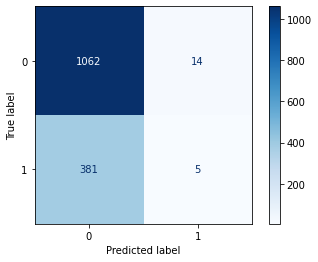

              precision    recall  f1-score   support

           0       0.74      0.99      0.84      1076
           1       0.26      0.01      0.02       386

    accuracy                           0.73      1462
   macro avg       0.50      0.50      0.43      1462
weighted avg       0.61      0.73      0.63      1462



In [65]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p4, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

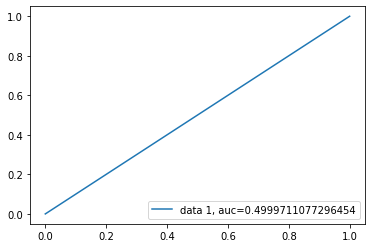

In [66]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 5 (01/03/2022 até 13/06/2022):

In [67]:
Pre_processing_models_5 = Pre_processing_models(periodo_5)
Pre_processing_models_5.run_graves()

df_p5 = Pre_processing_models_5.df
df_p5 = df_p5[list_features]
df_p5

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
2165,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.281818,0,1,2022-03-02
2169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,1,0,2022-03-07
2172,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0.554545,0,1,2022-03-12
2182,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.554545,0,1,2022-03-14
2185,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.700000,0,1,2022-06-08
36431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.672727,0,1,2022-06-09
36432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.672727,0,1,2022-06-10
36433,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.663636,1,0,2022-06-12


In [68]:
df2_p5 = pd.DataFrame()
df2_p5 = df_p5
df2_p5.set_index('data_notificacao', inplace=True)
df2_p5.sort_index(inplace=True)
df2_p5

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\4039150074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p5.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2022-03-02,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.281818,0,1
2022-03-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.636364,1,0
2022-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.681818,0,1
2022-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.836364,0,1
2022-03-02,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.427273,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2022-06-12,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,1
2022-06-12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.581818,0,1


#### Aplicação do modelo:

In [69]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 2)

#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_5 = []
best_params_5 = []

X = df2_p5.drop(labels=['death'], axis=1)
y = df2_p5['death']

"""X = df_p5[["SYMPTOM_COUGH", "SYMPTOM_AIR_INSUFFICIENCY", "SYMPTOM_FEVER", 'SYMPTOM_THROAT_CONDITION', 'SYMPTOM_HEADACHE',
    'DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY', 'DISEASE_TABAGIST', 'idade', 'sexo_Feminino','sexo_Masculino']]

y = df_p5['death'].astype(int)"""

for random_state in list_random_states:
    
    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)

    #mean_test_score, std_test_score, best_score, best_param = KNN_model(X_train,y_train)
    best_score, best_param = KNN_model(X_train,y_train)

    best_scores_5.append(best_score)
    best_params_5.append(best_param)


#armazenando as informações na lista para todos os periodos de 6 meses
best_scores_periodos_6meses.append(best_scores_5)
best_params_periodos_6meses.append(best_params_5)

########################################

best_score: 0.7427508245676592
best_params_: {'n_neighbors': 15}
########################################



In [70]:
X_train.index

Index(['2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02',
       '2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02',
       ...
       '2022-05-05', '2022-05-05', '2022-05-05', '2022-05-05', '2022-05-06',
       '2022-05-06', '2022-05-06', '2022-05-06', '2022-05-06', '2022-05-06'],
      dtype='object', name='data_notificacao', length=1109)

In [71]:
X_test.index

Index(['2022-05-06', '2022-05-06', '2022-05-07', '2022-05-07', '2022-05-07',
       '2022-05-07', '2022-05-07', '2022-05-08', '2022-05-08', '2022-05-08',
       ...
       '2022-06-11', '2022-06-11', '2022-06-12', '2022-06-12', '2022-06-12',
       '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12'],
      dtype='object', name='data_notificacao', length=554)

In [72]:
print(f'Best_score = {max(best_scores_periodos_6meses[4])}')
index = best_scores_periodos_6meses[4].index(max(best_scores_periodos_6meses[4]))
print(f'Best_params = {best_params_periodos_6meses[4][index]}')

Best_score = 0.7427508245676592
Best_params = {'n_neighbors': 15}


## Testando o modelo para os melhores parâmetros:

In [73]:
# parametrizando o modelo final
final_cl_p5 = KNeighborsClassifier(n_neighbors=15)

#treinando o modelo final
final_cl_p5.fit(X_train, y_train)


preds = final_cl_p5.predict(X_test)

accuracy_score(y_test, preds)

0.8014440433212996

In [74]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.27631578947368424
0.580626513983704
0.8014440433212996
0.828908910154334


In [75]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.2079207920792079
0.570847813258147
0.8014440433212996
0.8669543359528771


In [76]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6263594901181148

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


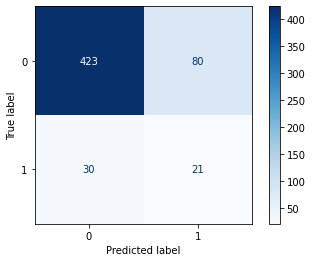

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       503
           1       0.21      0.41      0.28        51

    accuracy                           0.80       554
   macro avg       0.57      0.63      0.58       554
weighted avg       0.87      0.80      0.83       554



In [77]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p5, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

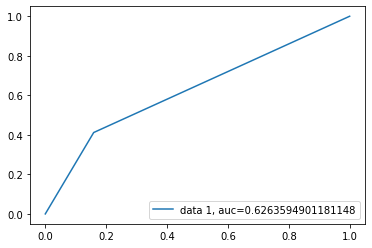

In [78]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Aplicando para os períodos de 3 meses:

In [79]:
df = pd.read_csv(r'C:\Users\gabri\Desktop\Git - Tcc\Estudo_dados_de_covid\Data\Casos Graves\df_casos_graves')

In [80]:
periodo_1 = df[(df['data_notificacao'] > '2020-02-26') & (df['data_notificacao'] < '2020-05-31')]
periodo_2 = df[(df['data_notificacao'] > '2020-06-01') & (df['data_notificacao'] < '2020-08-31')]
periodo_3 = df[(df['data_notificacao'] > '2020-09-01') & (df['data_notificacao'] < '2020-11-30')]
periodo_4 = df[(df['data_notificacao'] > '2020-12-01') & (df['data_notificacao'] < '2021-02-28')]
periodo_5 = df[(df['data_notificacao'] > '2021-03-01') & (df['data_notificacao'] < '2021-05-31')]
periodo_6 = df[(df['data_notificacao'] > '2021-06-01') & (df['data_notificacao'] < '2021-08-31')]
periodo_7 = df[(df['data_notificacao'] > '2021-09-01') & (df['data_notificacao'] < '2021-11-30')]
periodo_8 = df[(df['data_notificacao'] > '2021-12-01') & (df['data_notificacao'] < '2022-02-28')]
periodo_9 = df[(df['data_notificacao'] > '2022-03-01') & (df['data_notificacao'] < '2025-05-31')]
periodo_10 = df[(df['data_notificacao'] > '2022-06-01') & (df['data_notificacao'] < '2022-06-13')]

#### Criando listas para armazenamento dos melhores parâmetros:

In [81]:
best_scores_periodos_3meses = []
best_params_periodos_3meses = []

#### Período 1 (26/02/2020 até 31/05/2020):

In [82]:
Pre_processing_models_13m = Pre_processing_models(periodo_1)
Pre_processing_models_13m.run_graves()

df_p13m = Pre_processing_models_13m.df
df_p13m = df_p13m[list_features]
df_p13m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.486239,0,1,2020-05-30
24,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.633028,0,1,2020-05-17
25,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.642202,0,1,2020-05-17
26,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0.596330,0,1,2020-05-17
27,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.467890,0,1,2020-05-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36271,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.532110,1,0,2020-05-21
36272,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0.871560,1,0,2020-05-28
36274,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.614679,0,1,2020-05-13
36275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.623853,0,1,2020-05-12


In [83]:
df2_p13m = pd.DataFrame()
df2_p13m = df_p13m
df2_p13m.set_index('data_notificacao', inplace=True)
df2_p13m.sort_index(inplace=True)
df2_p13m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\697372499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p13m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-02-27,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0.293578,0,1
2020-02-27,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.330275,0,1
2020-02-27,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.275229,1,0
2020-02-27,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.229358,1,0
2020-02-29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.238532,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-30,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.330275,1,0
2020-05-30,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.330275,0,1
2020-05-30,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.605505,1,0


#### Aplicação do modelo:

In [84]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_1 = []
best_params_1 = []

X = df2_p13m.drop(labels=['death'], axis=1)
y = df2_p13m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_1.append(best_score)
    best_params_1.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_1)
best_params_periodos_3meses.append(best_params_1)

########################################

best_score: 0.8794579745677605
best_params_: {'n_neighbors': 27}
########################################



In [85]:
X_train.index

Index(['2020-02-27', '2020-02-27', '2020-02-27', '2020-02-27', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-04', '2020-03-04', '2020-03-04',
       ...
       '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07',
       '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07'],
      dtype='object', name='data_notificacao', length=7626)

In [86]:
X_test.index

Index(['2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07',
       '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07', '2020-05-07',
       ...
       '2020-05-30', '2020-05-30', '2020-05-30', '2020-05-30', '2020-05-30',
       '2020-05-30', '2020-05-30', '2020-05-30', '2020-05-30', '2020-05-30'],
      dtype='object', name='data_notificacao', length=3812)

In [87]:
print(f'Best_score = {max(best_scores_periodos_3meses[0])}')
index = best_scores_periodos_3meses[0].index(max(best_scores_periodos_3meses[0]))
print(f'Best_params = {best_params_periodos_3meses[0][index]}')

Best_score = 0.8794579745677605
Best_params = {'n_neighbors': 27}


## Testando o modelo para os melhores parâmetros:

In [88]:
# parametrizando o modelo final
final_cl_p13m = KNeighborsClassifier(n_neighbors=27)

#treinando o modelo final
final_cl_p13m.fit(X_train, y_train)


preds = final_cl_p13m.predict(X_test)

accuracy_score(y_test, preds)

0.75

In [89]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.4840281537628587
0.6595318196544949
0.75
0.7369707404387897


In [90]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.571611253196931
0.6838254285786636
0.75
0.733338608796941


In [91]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6488835451734798

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


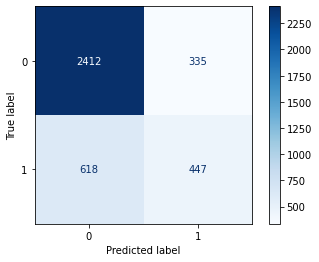

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2747
           1       0.57      0.42      0.48      1065

    accuracy                           0.75      3812
   macro avg       0.68      0.65      0.66      3812
weighted avg       0.73      0.75      0.74      3812



In [92]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p13m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

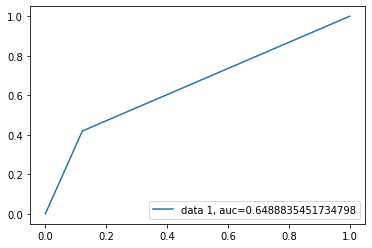

In [93]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 2 (01/06/2020 até 31/08/2020):

In [94]:
Pre_processing_models_23m = Pre_processing_models(periodo_2)
Pre_processing_models_23m.run_graves()

df_p23m = Pre_processing_models_23m.df
df_p23m = df_p23m[list_features]
df_p23m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
1,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2020-06-02
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.803738,1,0,2020-06-02
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.635514,0,1,2020-06-02
5,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.869159,0,1,2020-06-02
6,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.626168,1,0,2020-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36251,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.644860,1,0,2020-06-09
36252,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.654206,1,0,2020-06-23
36261,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.747664,0,1,2020-08-26
36270,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.766355,1,0,2020-08-13


In [95]:
df2_p23m = pd.DataFrame()
df2_p23m = df_p23m
df2_p23m.set_index('data_notificacao', inplace=True)
df2_p23m.sort_index(inplace=True)
df2_p23m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\1770633936.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p23m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2020-06-02,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.588785,0,1
2020-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.588785,1,0
2020-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.635514,0,1
2020-06-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.411215,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-30,1,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0.112150,1,0
2020-08-30,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.476636,0,1
2020-08-30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.065421,0,1


#### Aplicação do modelo:

In [96]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_2 = []
best_params_2 = []

X = df2_p23m.drop(labels=['death'], axis=1)
y = df2_p23m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_2.append(best_score)
    best_params_2.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_2)
best_params_periodos_3meses.append(best_params_2)


########################################

best_score: 0.7425010275163433
best_params_: {'n_neighbors': 29}
########################################



In [97]:
X_train.index

Index(['2020-06-02', '2020-06-02', '2020-06-02', '2020-06-02', '2020-06-02',
       '2020-06-02', '2020-06-02', '2020-06-02', '2020-06-02', '2020-06-02',
       ...
       '2020-07-23', '2020-07-23', '2020-07-23', '2020-07-23', '2020-07-23',
       '2020-07-23', '2020-07-24', '2020-07-24', '2020-07-24', '2020-07-24'],
      dtype='object', name='data_notificacao', length=3188)

In [98]:
X_test.index

Index(['2020-07-24', '2020-07-24', '2020-07-24', '2020-07-24', '2020-07-24',
       '2020-07-24', '2020-07-24', '2020-07-24', '2020-07-24', '2020-07-24',
       ...
       '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30',
       '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30', '2020-08-30'],
      dtype='object', name='data_notificacao', length=1593)

In [99]:
print(f'Best_score = {max(best_scores_periodos_3meses[1])}')
index = best_scores_periodos_3meses[1].index(max(best_scores_periodos_3meses[1]))
print(f'Best_params = {best_params_periodos_3meses[1][index]}')

Best_score = 0.7425010275163433
Best_params = {'n_neighbors': 29}


## Testando o modelo para os melhores parâmetros:

In [100]:
# parametrizando o modelo final
final_cl_p23m = KNeighborsClassifier(n_neighbors=29)

#treinando o modelo final
final_cl_p23m.fit(X_train, y_train)


preds = final_cl_p23m.predict(X_test)

accuracy_score(y_test, preds)

0.815442561205273

In [101]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.1694915254237288
0.5328389830508475
0.815442561205273
0.76617510932363


In [102]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.43478260869565216
0.6337298870249914
0.815442561205273
0.7614907569125708


In [103]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.5377233220666344

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


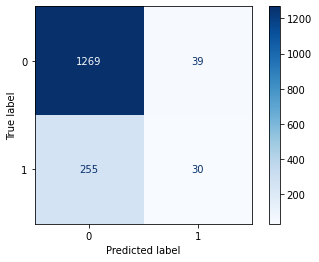

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1308
           1       0.43      0.11      0.17       285

    accuracy                           0.82      1593
   macro avg       0.63      0.54      0.53      1593
weighted avg       0.76      0.82      0.77      1593



In [104]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p23m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

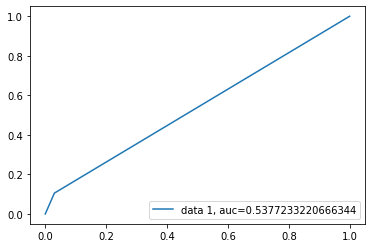

In [105]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 3 (01/09/2020 até 30/11/2020):

In [106]:
Pre_processing_models_33m = Pre_processing_models(periodo_3)
Pre_processing_models_33m.run_graves()

df_p33m = Pre_processing_models_33m.df
df_p33m = df_p33m[list_features]
df_p33m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0.807692,0,1,2020-09-16
432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.182692,0,1,2020-09-27
433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.875000,1,0,2020-09-30
434,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.548077,0,1,2020-09-30
436,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.807692,1,0,2020-11-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36168,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0.576923,1,0,2020-11-06
36169,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.586538,0,1,2020-11-25
36235,1,0,1,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0.605769,0,1,2020-10-19
36236,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0.519231,0,1,2020-10-14


In [107]:
df2_p33m = pd.DataFrame()
df2_p33m = df_p33m
df2_p33m.set_index('data_notificacao', inplace=True)
df2_p33m.sort_index(inplace=True)
df2_p33m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\2020330796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p33m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-09-02,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2020-09-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.625000,0,1
2020-09-02,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.384615,0,1
2020-09-02,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.836538,1,0
2020-09-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-29,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.807692,0,1
2020-11-29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.394231,0,1
2020-11-29,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0.528846,0,1


#### Aplicação do modelo:

In [108]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_3 = []
best_params_3 = []

X = df2_p33m.drop(labels=['death'], axis=1)
y = df2_p33m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_3.append(best_score)
    best_params_3.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_3)
best_params_periodos_3meses.append(best_params_3)


########################################

best_score: 0.7230306578024932
best_params_: {'n_neighbors': 23}
########################################



In [109]:
X_train.index

Index(['2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02',
       '2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02', '2020-09-02',
       ...
       '2020-11-02', '2020-11-02', '2020-11-02', '2020-11-02', '2020-11-02',
       '2020-11-02', '2020-11-02', '2020-11-02', '2020-11-02', '2020-11-03'],
      dtype='object', name='data_notificacao', length=1440)

In [110]:
X_test.index

Index(['2020-11-03', '2020-11-03', '2020-11-03', '2020-11-03', '2020-11-03',
       '2020-11-03', '2020-11-03', '2020-11-03', '2020-11-03', '2020-11-03',
       ...
       '2020-11-29', '2020-11-29', '2020-11-29', '2020-11-29', '2020-11-29',
       '2020-11-29', '2020-11-29', '2020-11-29', '2020-11-29', '2020-11-29'],
      dtype='object', name='data_notificacao', length=720)

In [111]:
print(f'Best_score = {max(best_scores_periodos_3meses[2])}')
index = best_scores_periodos_3meses[2].index(max(best_scores_periodos_3meses[2]))
print(f'Best_params = {best_params_periodos_3meses[2][index]}')

Best_score = 0.7230306578024932
Best_params = {'n_neighbors': 23}


## Testando o modelo para os melhores parâmetros:

In [112]:
# parametrizando o modelo final
final_cl_p33m = KNeighborsClassifier(n_neighbors=23)

#treinando o modelo final
final_cl_p33m.fit(X_train, y_train)


preds = final_cl_p33m.predict(X_test)

accuracy_score(y_test, preds)

0.6986111111111111

In [113]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.18726591760299624
0.5011350900887956
0.6986111111111111
0.6066300063965226


In [114]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.8928571428571429
0.7918042939719241
0.6986111111111111
0.7578393086521699


In [115]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.5491827521116224

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


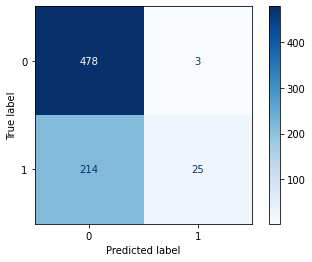

              precision    recall  f1-score   support

           0       0.69      0.99      0.82       481
           1       0.89      0.10      0.19       239

    accuracy                           0.70       720
   macro avg       0.79      0.55      0.50       720
weighted avg       0.76      0.70      0.61       720



In [116]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p33m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

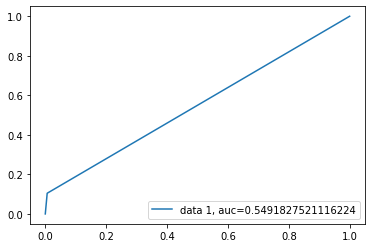

In [117]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 4 (01/12/2020 até 28/02/2021):

In [118]:
Pre_processing_models_43m = Pre_processing_models(periodo_4)
Pre_processing_models_43m.run_graves()

df_p43m = Pre_processing_models_43m.df
df_p43m = df_p43m[list_features]
df_p43m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
937,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.517544,1,0,2021-01-19
938,1,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0.350877,0,1,2021-01-11
939,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.771930,1,0,2021-01-06
970,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.026316,1,0,2021-02-15
979,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.456140,1,0,2021-01-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36245,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.666667,1,0,2021-01-18
36246,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.570175,1,0,2020-12-30
36247,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.429825,0,1,2021-02-02
36351,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0.798246,1,0,2021-01-13


In [119]:
df2_p43m = pd.DataFrame()
df2_p43m = df_p43m
df2_p43m.set_index('data_notificacao', inplace=True)
df2_p43m.sort_index(inplace=True)
df2_p43m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\2526461818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p43m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2020-12-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.482456,1,0
2020-12-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.763158,0,1
2020-12-02,1,0,1,1,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0.280702,0,1
2020-12-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.482456,0,1
2020-12-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.271930,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.719298,1,0
2021-02-27,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.684211,1,0
2021-02-27,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.596491,1,0


#### Aplicação do modelo:

In [120]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_4 = []
best_params_4 = []

X = df2_p43m.drop(labels=['death'], axis=1)
y = df2_p43m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_4.append(best_score)
    best_params_4.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_4)
best_params_periodos_3meses.append(best_params_4)


########################################

best_score: 0.7252917821479719
best_params_: {'n_neighbors': 21}
########################################



In [121]:
X_train.index

Index(['2020-12-02', '2020-12-02', '2020-12-02', '2020-12-02', '2020-12-02',
       '2020-12-02', '2020-12-02', '2020-12-02', '2020-12-02', '2020-12-02',
       ...
       '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31',
       '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31'],
      dtype='object', name='data_notificacao', length=1891)

In [122]:
X_test.index

Index(['2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31',
       '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31', '2021-01-31',
       ...
       '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27',
       '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27', '2021-02-27'],
      dtype='object', name='data_notificacao', length=945)

In [123]:
print(f'Best_score = {max(best_scores_periodos_3meses[3])}')
index = best_scores_periodos_3meses[3].index(max(best_scores_periodos_3meses[3]))
print(f'Best_params = {best_params_periodos_3meses[3][index]}')

Best_score = 0.7252917821479719
Best_params = {'n_neighbors': 21}


## Testando o modelo para os melhores parâmetros:

In [124]:
# parametrizando o modelo final
final_cl_p43m = KNeighborsClassifier(n_neighbors=21)

#treinando o modelo final
final_cl_p43m.fit(X_train, y_train)


preds = final_cl_p43m.predict(X_test)

accuracy_score(y_test, preds)

0.7206349206349206

In [125]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.5092936802973977
0.6570137040540243
0.7206349206349207
0.7034399972346784


In [126]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.6401869158878505
0.6921864811997391
0.7206349206349206
0.7085292017263327


In [127]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.649422973698336

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


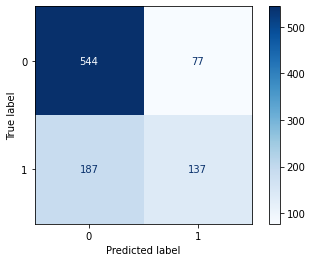

              precision    recall  f1-score   support

           0       0.74      0.88      0.80       621
           1       0.64      0.42      0.51       324

    accuracy                           0.72       945
   macro avg       0.69      0.65      0.66       945
weighted avg       0.71      0.72      0.70       945



In [128]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p43m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

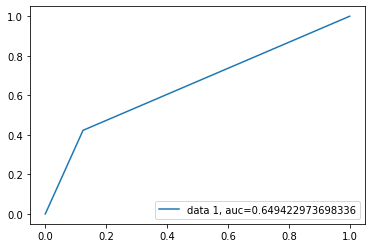

In [129]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 5 (01/03/2021 até 31/05/2021):

In [130]:
Pre_processing_models_53m = Pre_processing_models(periodo_5)
Pre_processing_models_53m.run_graves()

df_p53m = Pre_processing_models_53m.df
df_p53m = df_p53m[list_features]
df_p53m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
952,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.429825,0,1,2021-05-07
953,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.315789,1,0,2021-04-27
954,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.368421,1,0,2021-04-14
955,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0.394737,0,1,2021-04-10
956,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.377193,0,1,2021-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36332,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.333333,1,0,2021-05-18
36333,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.631579,1,0,2021-03-12
36334,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0.438596,1,0,2021-05-25
36362,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.491228,1,0,2021-05-11


In [131]:
df2_p53m = pd.DataFrame()
df2_p53m = df_p53m
df2_p53m.set_index('data_notificacao', inplace=True)
df2_p53m.sort_index(inplace=True)
df2_p53m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\1841919072.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p53m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2021-03-02,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.333333,0,1
2021-03-02,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0.412281,0,1
2021-03-02,1,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0.482456,1,0
2021-03-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.491228,1,0
2021-03-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.008772,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-30,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.333333,0,1
2021-05-30,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.043860,0,1
2021-05-30,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.447368,0,1


#### Aplicação do modelo:

In [132]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_5 = []
best_params_5 = []

X = df2_p53m.drop(labels=['death'], axis=1)
y = df2_p53m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_5.append(best_score)
    best_params_5.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_5)
best_params_periodos_3meses.append(best_params_5)


########################################

best_score: 0.7512528927778503
best_params_: {'n_neighbors': 30}
########################################



In [133]:
X_train.index

Index(['2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02',
       '2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02', '2021-03-02',
       ...
       '2021-04-29', '2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30',
       '2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30'],
      dtype='object', name='data_notificacao', length=3736)

In [134]:
X_test.index

Index(['2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30',
       '2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30', '2021-04-30',
       ...
       '2021-05-30', '2021-05-30', '2021-05-30', '2021-05-30', '2021-05-30',
       '2021-05-30', '2021-05-30', '2021-05-30', '2021-05-30', '2021-05-30'],
      dtype='object', name='data_notificacao', length=1867)

In [135]:
print(f'Best_score = {max(best_scores_periodos_3meses[4])}')
index = best_scores_periodos_3meses[4].index(max(best_scores_periodos_3meses[4]))
print(f'Best_params = {best_params_periodos_3meses[4][index]}')

Best_score = 0.7512528927778503
Best_params = {'n_neighbors': 30}


## Testando o modelo para os melhores parâmetros:

In [136]:
# parametrizando o modelo final
final_cl_p53m = KNeighborsClassifier(n_neighbors=30)

#treinando o modelo final
final_cl_p53m.fit(X_train, y_train)


preds = final_cl_p53m.predict(X_test)

accuracy_score(y_test, preds)

0.7525441885377611

In [137]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.4539007092198582
0.6469642050254415
0.7525441885377611
0.7217284832618833


In [138]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.7007299270072993
0.7310931493165812
0.7525441885377611
0.7428513762740588


In [139]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6361719361719361

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


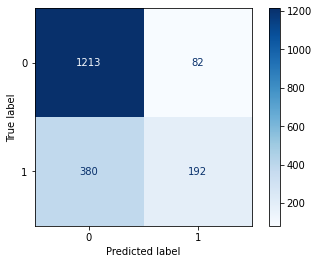

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      1295
           1       0.70      0.34      0.45       572

    accuracy                           0.75      1867
   macro avg       0.73      0.64      0.65      1867
weighted avg       0.74      0.75      0.72      1867



In [140]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p53m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

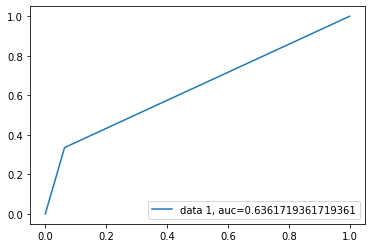

In [141]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 6 (01/06/2021 até 31/08/2021):

In [142]:
Pre_processing_models_63m = Pre_processing_models(periodo_6)
Pre_processing_models_63m.run_graves()

df_p63m = Pre_processing_models_63m.df
df_p63m = df_p63m[list_features]
df_p63m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
1661,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0.456140,1,0,2021-07-05
1663,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.438596,0,1,2021-06-06
1664,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.684211,0,1,2021-06-16
1665,1,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0.675439,0,1,2021-07-09
1667,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.605263,1,0,2021-07-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36359,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.570175,0,1,2021-06-26
36364,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.622807,1,0,2021-06-09
36371,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.403509,0,1,2021-07-01
36372,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.622807,0,1,2021-06-18


In [143]:
df2_p63m = pd.DataFrame()
df2_p63m = df_p63m
df2_p63m.set_index('data_notificacao', inplace=True)
df2_p63m.sort_index(inplace=True)
df2_p63m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\2091768356.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p63m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2021-06-02,1,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0.385965,0,1
2021-06-02,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.754386,1,0
2021-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.464912,0,1
2021-06-02,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.342105,0,1
2021-06-02,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.526316,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.543860,0,1
2021-08-30,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.815789,1,0
2021-08-30,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.508772,1,0


#### Aplicação do modelo:

In [144]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_6 = []
best_params_6 = []

X = df2_p63m.drop(labels=['death'], axis=1)
y = df2_p63m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_6.append(best_score)
    best_params_6.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_6)
best_params_periodos_3meses.append(best_params_6)


########################################

best_score: 0.7059939317008803
best_params_: {'n_neighbors': 28}
########################################



In [145]:
X_train.index

Index(['2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02',
       '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02', '2021-06-02',
       ...
       '2021-07-14', '2021-07-14', '2021-07-14', '2021-07-14', '2021-07-14',
       '2021-07-14', '2021-07-14', '2021-07-14', '2021-07-15', '2021-07-15'],
      dtype='object', name='data_notificacao', length=1968)

In [146]:
X_test.index

Index(['2021-07-15', '2021-07-15', '2021-07-15', '2021-07-15', '2021-07-15',
       '2021-07-15', '2021-07-15', '2021-07-15', '2021-07-15', '2021-07-15',
       ...
       '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30',
       '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30', '2021-08-30'],
      dtype='object', name='data_notificacao', length=983)

In [147]:
print(f'Best_score = {max(best_scores_periodos_3meses[5])}')
index = best_scores_periodos_3meses[5].index(max(best_scores_periodos_3meses[5]))
print(f'Best_params = {best_params_periodos_3meses[5][index]}')

Best_score = 0.7059939317008803
Best_params = {'n_neighbors': 28}


## Testando o modelo para os melhores parâmetros:

In [148]:
# parametrizando o modelo final
final_cl_p63m = KNeighborsClassifier(n_neighbors=28)

#treinando o modelo final
final_cl_p63m.fit(X_train, y_train)


preds = final_cl_p63m.predict(X_test)

accuracy_score(y_test, preds)

0.7395727365208545

In [149]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.45299145299145305
0.64104846347837
0.7395727365208545
0.7043718312008211


In [150]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.7464788732394366
0.7424427659895162
0.7395727365208545
0.7410837105472745


In [151]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6351794268425918

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


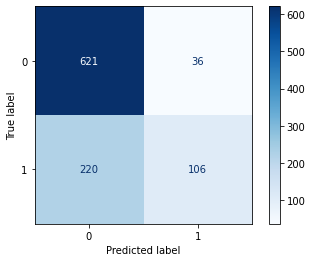

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       657
           1       0.75      0.33      0.45       326

    accuracy                           0.74       983
   macro avg       0.74      0.64      0.64       983
weighted avg       0.74      0.74      0.70       983



In [152]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p63m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

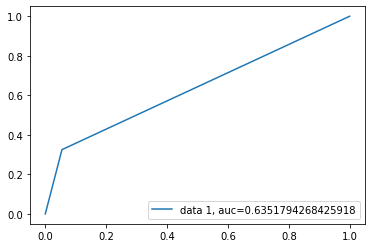

In [153]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 7 (01/09/2021 até 30/11/2021):

In [154]:
Pre_processing_models_73m = Pre_processing_models(periodo_7)
Pre_processing_models_73m.run_graves()

df_p73m = Pre_processing_models_73m.df
df_p73m = df_p73m[list_features]
df_p73m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
1804,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.258929,0,1,2021-09-18
1805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.250000,1,0,2021-09-25
1807,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.741071,0,1,2021-09-08
1808,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.589286,1,0,2021-10-07
1809,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0.544643,0,1,2021-10-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.544643,1,0,2021-11-19
36323,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.500000,1,0,2021-11-24
36335,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.669643,0,1,2021-10-24
36340,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.687500,0,1,2021-11-01


In [155]:
df2_p73m = pd.DataFrame()
df2_p73m = df_p73m
df2_p73m.set_index('data_notificacao', inplace=True)
df2_p73m.sort_index(inplace=True)
df2_p73m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\3044687016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p73m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2021-09-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0.517857,1,0
2021-09-02,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.508929,0,1
2021-09-02,1,0,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0.392857,0,1
2021-09-02,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0.758929,0,1
2021-09-02,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.383929,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.785714,1,0
2021-11-29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.312500,0,1
2021-11-29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.500000,0,1


#### Aplicação do modelo:

In [156]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_7 = []
best_params_7 = []

X = df2_p73m.drop(labels=['death'], axis=1)
y = df2_p73m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_7.append(best_score)
    best_params_7.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_7)
best_params_periodos_3meses.append(best_params_7)


########################################

best_score: 0.6913094188382473
best_params_: {'n_neighbors': 26}
########################################



In [157]:
X_train.index

Index(['2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02',
       '2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02', '2021-09-02',
       ...
       '2021-10-26', '2021-10-26', '2021-10-26', '2021-10-26', '2021-10-27',
       '2021-10-27', '2021-10-27', '2021-10-27', '2021-10-27', '2021-10-27'],
      dtype='object', name='data_notificacao', length=1085)

In [158]:
X_test.index

Index(['2021-10-27', '2021-10-27', '2021-10-27', '2021-10-27', '2021-10-27',
       '2021-10-27', '2021-10-27', '2021-10-27', '2021-10-27', '2021-10-27',
       ...
       '2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29',
       '2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29', '2021-11-29'],
      dtype='object', name='data_notificacao', length=542)

In [159]:
print(f'Best_score = {max(best_scores_periodos_3meses[6])}')
index = best_scores_periodos_3meses[6].index(max(best_scores_periodos_3meses[6]))
print(f'Best_params = {best_params_periodos_3meses[6][index]}')

Best_score = 0.6913094188382473
Best_params = {'n_neighbors': 26}


## Testando o modelo para os melhores parâmetros:

In [160]:
# parametrizando o modelo final
final_cl_p73m = KNeighborsClassifier(n_neighbors=26)

#treinando o modelo final
final_cl_p73m.fit(X_train, y_train)


preds = final_cl_p73m.predict(X_test)

accuracy_score(y_test, preds)

0.8007380073800738

In [161]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.03571428571428571
0.4623015873015873
0.8007380073800738
0.7204577402916886


In [162]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.4
0.6022346368715084
0.8007380073800738
0.7246201735760375


In [163]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.5058975185304544

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


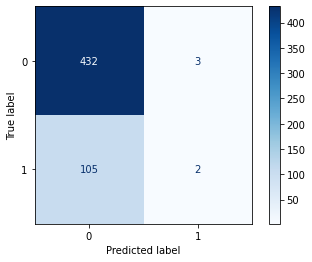

              precision    recall  f1-score   support

           0       0.80      0.99      0.89       435
           1       0.40      0.02      0.04       107

    accuracy                           0.80       542
   macro avg       0.60      0.51      0.46       542
weighted avg       0.72      0.80      0.72       542



In [164]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p73m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

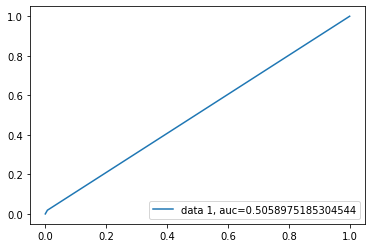

In [165]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 8 (01/12/2021 até 28/02/2022):

In [166]:
Pre_processing_models_83m = Pre_processing_models(periodo_8)
Pre_processing_models_83m.run_graves()

df_p83m = Pre_processing_models_83m.df
df_p83m = df_p83m[list_features]
df_p83m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
1825,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.495652,0,1,2021-12-03
1826,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.713043,1,0,2021-12-02
1827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.721739,0,1,2021-12-13
1828,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.643478,1,0,2021-12-17
1829,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.365217,0,1,2021-12-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36350,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.643478,1,0,2022-01-12
36360,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.234783,0,1,2022-02-26
36361,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.582609,0,1,2021-12-30
36368,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.756522,0,1,2022-02-02


In [167]:
df2_p83m = pd.DataFrame()
df2_p83m = df_p83m
df2_p83m.set_index('data_notificacao', inplace=True)
df2_p83m.sort_index(inplace=True)
df2_p83m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\1159271158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p83m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2021-12-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2021-12-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.008696,1,0
2021-12-02,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.591304,0,1
2021-12-02,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.347826,0,1
2021-12-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.408696,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-27,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.217391,1,0
2022-02-27,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.513043,0,1
2022-02-27,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0.391304,0,1


#### Aplicação do modelo:

In [168]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_8 = []
best_params_8 = []

X = df2_p83m.drop(labels=['death'], axis=1)
y = df2_p83m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_8.append(best_score)
    best_params_8.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_8)
best_params_periodos_3meses.append(best_params_8)


########################################

best_score: 0.6355030558316684
best_params_: {'n_neighbors': 30}
########################################



In [169]:
X_train.index

Index(['2021-12-02', '2021-12-02', '2021-12-02', '2021-12-02', '2021-12-02',
       '2021-12-02', '2021-12-02', '2021-12-02', '2021-12-02', '2021-12-02',
       ...
       '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26',
       '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26'],
      dtype='object', name='data_notificacao', length=1818)

In [170]:
X_test.index

Index(['2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26',
       '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26', '2022-01-26',
       ...
       '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27',
       '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27', '2022-02-27'],
      dtype='object', name='data_notificacao', length=909)

In [171]:
print(f'Best_score = {max(best_scores_periodos_3meses[7])}')
index = best_scores_periodos_3meses[7].index(max(best_scores_periodos_3meses[7]))
print(f'Best_params = {best_params_periodos_3meses[7][index]}')

Best_score = 0.6355030558316684
Best_params = {'n_neighbors': 30}


## Testando o modelo para os melhores parâmetros:

In [172]:
# parametrizando o modelo final
final_cl_p83m = KNeighborsClassifier(n_neighbors=30)

#treinando o modelo final
final_cl_p83m.fit(X_train, y_train)


preds = final_cl_p83m.predict(X_test)

accuracy_score(y_test, preds)

0.7172717271727173

In [173]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.0
0.4176809737347854
0.7172717271727174
0.6010194869583051


In [174]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.0
0.35942668136714445
0.7172717271727173
0.5171948286339109


In [175]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.4984709480122324

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


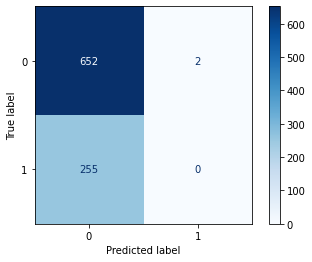

              precision    recall  f1-score   support

           0       0.72      1.00      0.84       654
           1       0.00      0.00      0.00       255

    accuracy                           0.72       909
   macro avg       0.36      0.50      0.42       909
weighted avg       0.52      0.72      0.60       909



In [176]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p83m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

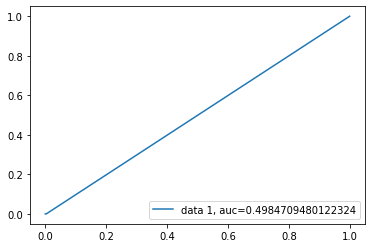

In [177]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 9 (01/03/2022 até 31/05/2022):

In [178]:
Pre_processing_models_93m = Pre_processing_models(periodo_9)
Pre_processing_models_93m.run_graves()

df_p93m = Pre_processing_models_93m.df
df_p93m = df_p93m[list_features]
df_p93m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
2165,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0.281818,0,1,2022-03-02
2169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.600000,1,0,2022-03-07
2172,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0.554545,0,1,2022-03-12
2182,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.554545,0,1,2022-03-14
2185,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-03-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.700000,0,1,2022-06-08
36431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.672727,0,1,2022-06-09
36432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.672727,0,1,2022-06-10
36433,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.663636,1,0,2022-06-12


In [179]:
df2_p93m = pd.DataFrame()
df2_p93m = df_p93m
df2_p93m.set_index('data_notificacao', inplace=True)
df2_p93m.sort_index(inplace=True)
df2_p93m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\4044059035.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p93m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2022-03-02,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0.281818,0,1
2022-03-02,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.672727,1,0
2022-03-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.809091,1,0
2022-03-02,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.618182,1,0
2022-03-02,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.454545,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.654545,0,1
2022-06-12,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.663636,1,0
2022-06-12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.600000,1,0


#### Aplicação do modelo:

In [180]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_9 = []
best_params_9 = []

X = df2_p93m.drop(labels=['death'], axis=1)
y = df2_p93m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_9.append(best_score)
    best_params_9.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_9)
best_params_periodos_3meses.append(best_params_9)


########################################

best_score: 0.7465292184638326
best_params_: {'n_neighbors': 11}
########################################



In [181]:
X_train.index

Index(['2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02',
       '2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02', '2022-03-02',
       ...
       '2022-05-05', '2022-05-05', '2022-05-05', '2022-05-06', '2022-05-06',
       '2022-05-06', '2022-05-06', '2022-05-06', '2022-05-06', '2022-05-06'],
      dtype='object', name='data_notificacao', length=1110)

In [182]:
X_test.index

Index(['2022-05-06', '2022-05-07', '2022-05-07', '2022-05-07', '2022-05-07',
       '2022-05-07', '2022-05-08', '2022-05-08', '2022-05-08', '2022-05-08',
       ...
       '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12',
       '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-13', '2022-06-13'],
      dtype='object', name='data_notificacao', length=555)

In [183]:
print(f'Best_score = {max(best_scores_periodos_3meses[8])}')
index = best_scores_periodos_3meses[8].index(max(best_scores_periodos_3meses[8]))
print(f'Best_params = {best_params_periodos_3meses[8][index]}')

Best_score = 0.7465292184638326
Best_params = {'n_neighbors': 11}


## Testando o modelo para os melhores parâmetros:

In [184]:
# parametrizando o modelo final
final_cl_p93m = KNeighborsClassifier(n_neighbors=11)

#treinando o modelo final
final_cl_p93m.fit(X_train, y_train)


preds = final_cl_p93m.predict(X_test)

accuracy_score(y_test, preds)

0.8036036036036036

In [185]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.28758169934640526
0.5868420513450939
0.8036036036036036
0.8311032035169966


In [186]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.21568627450980393
0.5758343072328269
0.8036036036036036
0.8697929717797268


In [187]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.6363211951447245

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


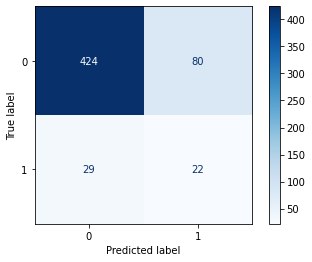

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       504
           1       0.22      0.43      0.29        51

    accuracy                           0.80       555
   macro avg       0.58      0.64      0.59       555
weighted avg       0.87      0.80      0.83       555



In [189]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p93m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

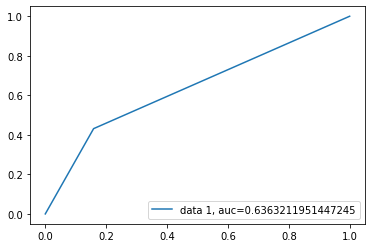

In [190]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#### Período 10 (01/06/2022 até 13/06/2022):

In [191]:
Pre_processing_models_103m = Pre_processing_models(periodo_10)
Pre_processing_models_103m.run_graves()

df_p103m = Pre_processing_models_103m.df
df_p103m = df_p103m[list_features]
df_p103m

,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
3889,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-02
3893,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,1,0,2022-06-06
3894,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-08
3895,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-11
3975,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.833333,1,0,2022-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.754902,0,1,2022-06-08
36431,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.725490,0,1,2022-06-09
36432,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.725490,0,1,2022-06-10
36433,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.715686,1,0,2022-06-12


In [192]:
df2_p103m = pd.DataFrame()
df2_p103m = df_p103m
df2_p103m.set_index('data_notificacao', inplace=True)
df2_p103m.sort_index(inplace=True)
df2_p103m

C:\Users\gabri\AppData\Local\Temp\ipykernel_21132\639333234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_p103m.sort_index(inplace=True)


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_KIDNEY,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino
data_notificacao,,,,,,,,,,,,,,,,,,,,,
2022-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,1
2022-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,1
2022-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.009804,1,0
2022-06-02,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2022-06-02,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.254902,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.627451,0,1
2022-06-12,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,1,0
2022-06-12,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.235294,0,1


#### Aplicação do modelo:

In [193]:
#utilizando diferentes random_states para mudar os conjuntos de treino e teste
list_random_states = [42]

#listas para armazenar os resutados
best_scores_10 = []
best_params_10 = []

X = df2_p103m.drop(labels=['death'], axis=1)
y = df2_p103m['death']

for random_state in list_random_states:

    for train_index, test_index in tss.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_score, best_param = KNN_model(X_train,y_train)

    
    best_scores_10.append(best_score)
    best_params_10.append(best_param)


#armazenando as informações na lista para todos os periodos de 3 meses
best_scores_periodos_3meses.append(best_scores_10)
best_params_periodos_3meses.append(best_params_10)


########################################

best_score: 0.7740476190476191
best_params_: {'n_neighbors': 11}
########################################



In [194]:
X_train.index

Index(['2022-06-02', '2022-06-02', '2022-06-02', '2022-06-02', '2022-06-02',
       '2022-06-02', '2022-06-02', '2022-06-02', '2022-06-02', '2022-06-02',
       ...
       '2022-06-08', '2022-06-08', '2022-06-08', '2022-06-08', '2022-06-08',
       '2022-06-08', '2022-06-08', '2022-06-08', '2022-06-08', '2022-06-08'],
      dtype='object', name='data_notificacao', length=115)

In [195]:
X_test.index

Index(['2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09',
       '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09',
       '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09',
       '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09', '2022-06-09',
       '2022-06-09', '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10',
       '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10',
       '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10',
       '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10', '2022-06-10',
       '2022-06-10', '2022-06-10', '2022-06-11', '2022-06-11', '2022-06-11',
       '2022-06-11', '2022-06-11', '2022-06-11', '2022-06-11', '2022-06-12',
       '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12', '2022-06-12',
       '2022-06-12', '2022-06-12'],
      dtype='object', name='data_notificacao')

In [196]:
print(f'Best_score = {max(best_scores_periodos_3meses[9])}')
index = best_scores_periodos_3meses[9].index(max(best_scores_periodos_3meses[9]))
print(f'Best_params = {best_params_periodos_3meses[9][index]}')

Best_score = 0.7740476190476191
Best_params = {'n_neighbors': 11}


## Testando o modelo para os melhores parâmetros:

In [197]:
# parametrizando o modelo final
final_cl_p103m = KNeighborsClassifier(n_neighbors=11)

#treinando o modelo final
final_cl_p103m.fit(X_train, y_train)


preds = final_cl_p103m.predict(X_test)

accuracy_score(y_test, preds)

0.9824561403508771

In [198]:
from sklearn.metrics import f1_score
print(f1_score(y_test, preds))
print(f1_score(y_test, preds, average='macro'))
print(f1_score(y_test, preds, average='micro'))
print(f1_score(y_test, preds, average='weighted'))

0.0
0.49557522123893805
0.9824561403508771
0.9737618382238783


In [199]:
from sklearn.metrics import precision_score
print(precision_score(y_test, preds))
print(precision_score(y_test, preds, average='macro'))
print(precision_score(y_test, preds, average='micro'))
print(precision_score(y_test, preds, average='weighted'))

0.0
0.49122807017543857
0.9824561403508771
0.9652200677131425


C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is i

In [200]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds, multi_class='ovr')

0.5

#### Matriz de Confusão e Classification Report:

C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


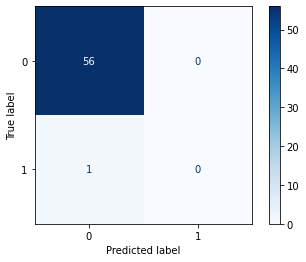

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       0.00      0.00      0.00         1

    accuracy                           0.98        57
   macro avg       0.49      0.50      0.50        57
weighted avg       0.97      0.98      0.97        57



C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\gabri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: Unde

In [201]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix(y_test, preds)
matrix = plot_confusion_matrix(final_cl_p103m, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, preds))

#### Curva ROC:

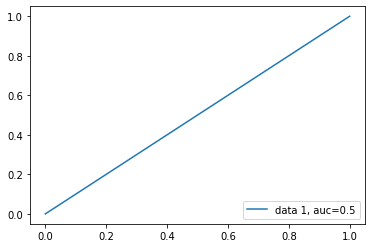

In [202]:
from sklearn import metrics
#y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
auc = metrics.roc_auc_score(y_test, preds)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()